# 📈 Phase 3: EDA & Business Rules Validation

Este notebook ejecuta el Análisis Exploratorio de Datos (EDA) guiado por las reglas de negocio definidas en `config.yaml`.

**Objetivos:**
1. Validar la calidad de la serie temporal post-limpieza.
2. Confirmar la estacionalidad y tendencia (Hitos: Covid, Retail).
3. Verificar la significancia de variables exógenas (Feria de Flores, Semana Santa, Macro).
4. Definir parámetros para el modelado (Lags, Diferenciación).

In [1]:
# 1️⃣ Carga de Datos y Configuración
import os
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Configuración Visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Cargar Configuración
with open('../config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Rutas
FILE_PATH = os.path.join("..", config['paths']['cleansed_data'], config['eda']['input']['sales_file'])
MACRO_PATH = os.path.join("..", config['paths']['features_data'], config['eda']['input']['macro_file'])

# Carga de Datos
df = pd.read_csv(FILE_PATH, parse_dates=['fecha'], index_col='fecha')
df.sort_index(inplace=True)
df['unidades'] = df['unidades'].astype(float)

# Carga Macro (Opcional por ahora)
try:
    df_macro = pd.read_csv(MACRO_PATH, parse_dates=['fecha'], index_col='fecha')
    print("✅ Datos macroeconómicos cargados.")
except FileNotFoundError:
    print("⚠️ Archivo macro no encontrado, se omitirá su análisis.")

print(f"✅ Dataset Ventas cargado: {df.shape[0]} registros desde {df.index.min().date()} hasta {df.index.max().date()}")
df.head()

✅ Datos macroeconómicos cargados.
✅ Dataset Ventas cargado: 83 registros desde 2018-12-01 hasta 2025-10-01


,unidades,es_atipico
fecha,,
2018-12-01,29549.0,0
2019-01-01,21716.0,0
2019-02-01,12292.0,0
2019-03-01,15179.0,0
2019-04-01,11843.0,0


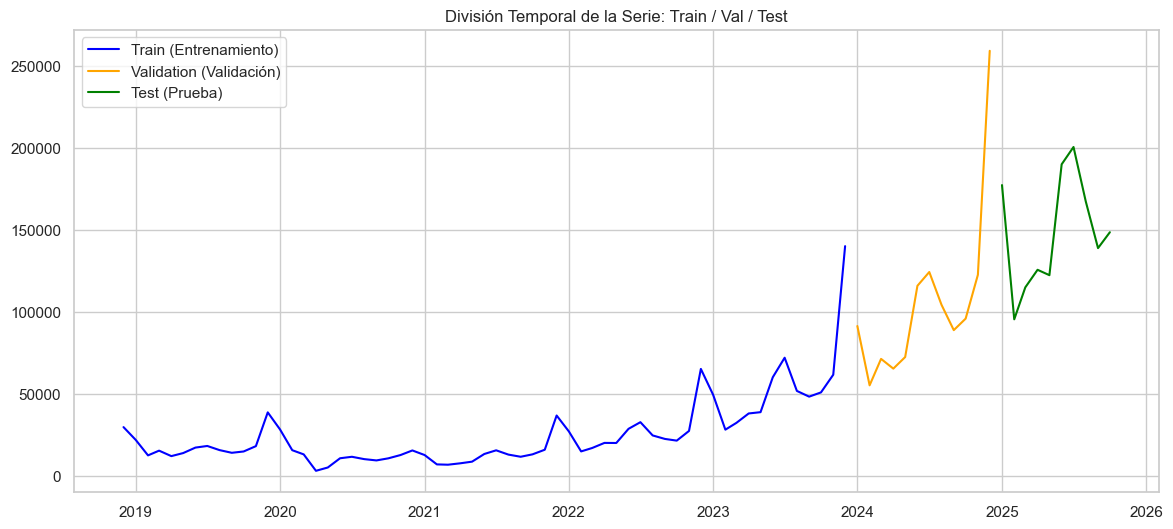

📊 Estadísticas Descriptivas por Set (Check for Drift): 
           Train  Validation       Test
count      61.00       12.00      10.00
mean    25131.72   105458.42  148042.90
std     21942.90    53434.48   34755.10
min      2876.00    55046.00   95338.00
25%     12502.00    72032.25  123107.00
50%     16804.00    93500.50  143654.50
75%     29549.00   117483.75  174786.75
max    140009.00   259241.00  200527.00

⚠️ Cambio porcentual en la media (Train -> Val): 319.62%
🚨 ALERTA DE DRIFT: La media de validación difiere significativamente del entrenamiento (>20%). Review required.


In [2]:
# 2️⃣ División del Split (Train / Val / Test) y Análisis de Drift
# Usamos las fechas fijas definidas en config.yaml

split_conf = config['eda']['splitting']

train_end = split_conf['train']['end_date']
val_start = split_conf['validation']['start_date']
val_end = split_conf['validation']['end_date']
test_start = split_conf['test']['start_date']
test_end = split_conf['test']['end_date']

# Slicing
train = df.loc[:train_end].copy()
val = df.loc[val_start:val_end].copy()
test = df.loc[test_start:test_end].copy()

# Visualización del Split
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['unidades'], label='Train (Entrenamiento)', color='blue')
plt.plot(val.index, val['unidades'], label='Validation (Validación)', color='orange')
plt.plot(test.index, test['unidades'], label='Test (Prueba)', color='green')
plt.title('División Temporal de la Serie: Train / Val / Test')
plt.legend()
plt.show()

# Estadísticas Descriptivas para Detectar Data Drift
stats_summary = pd.DataFrame({
    'Train': train['unidades'].describe(),
    'Validation': val['unidades'].describe(),
    'Test': test['unidades'].describe()
})

print("📊 Estadísticas Descriptivas por Set (Check for Drift): ")
print(stats_summary.round(2))

# Validación Rápida de Medias
mean_diff = ((val['unidades'].mean() - train['unidades'].mean()) / train['unidades'].mean()) * 100
print(f"\n⚠️ Cambio porcentual en la media (Train -> Val): {mean_diff:.2f}%")
if abs(mean_diff) > 20:
    print("🚨 ALERTA DE DRIFT: La media de validación difiere significativamente del entrenamiento (>20%). Review required.")

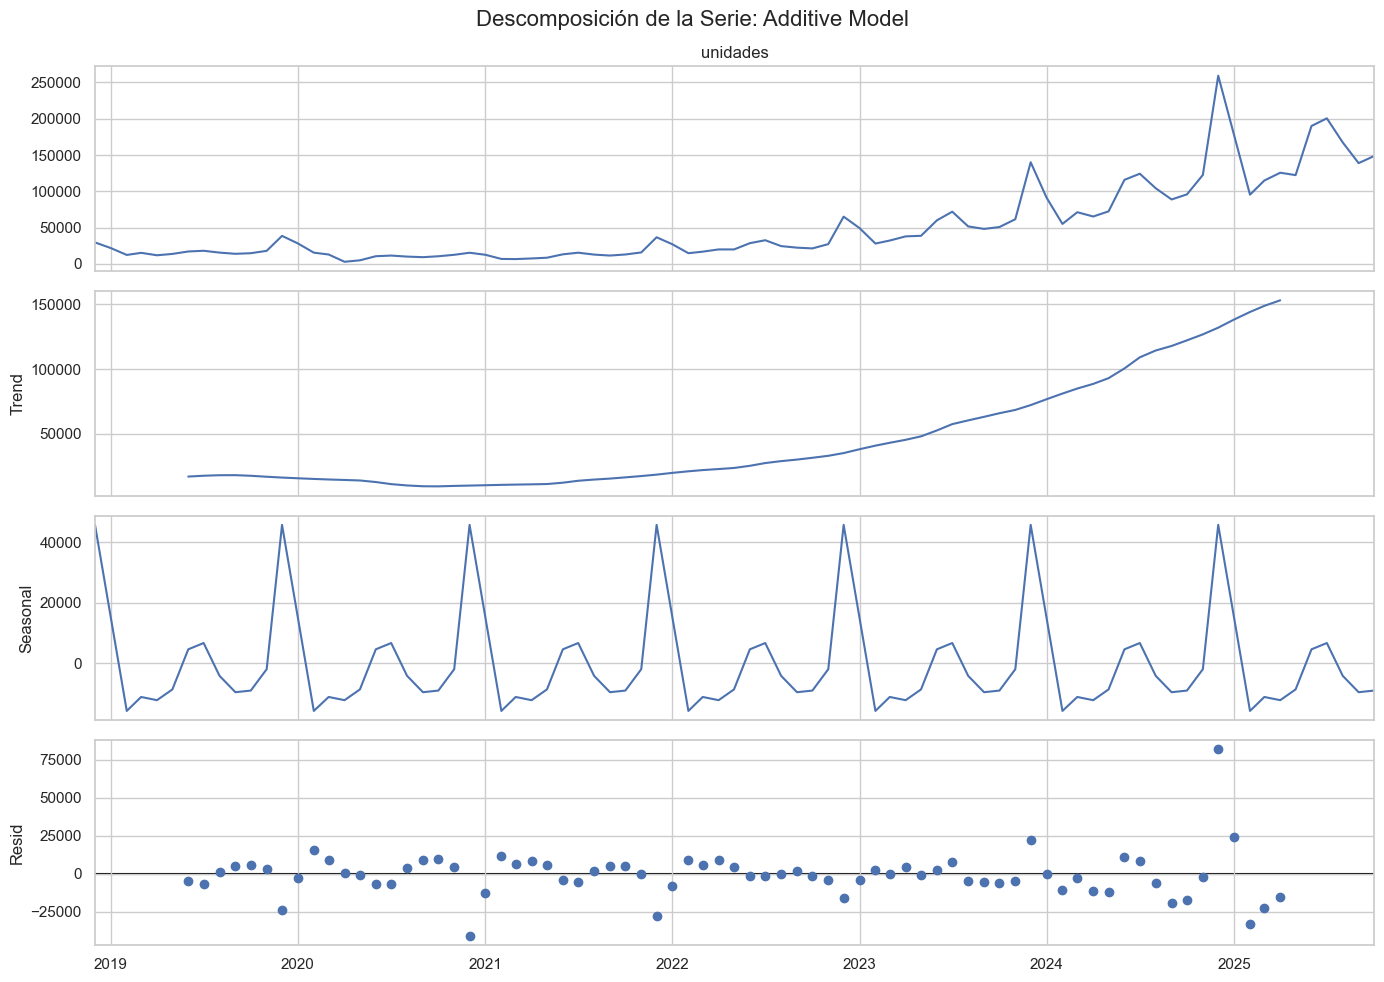

In [3]:
# 3️⃣ Descomposición de la Serie de Tiempo
# Separar Tendencia, Estacionalidad y Residuo para entender los componentes.

from statsmodels.tsa.seasonal import seasonal_decompose

# Usamos toda la serie completa para ver la historia global
decomposition = seasonal_decompose(df['unidades'], model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Descomposición de la Serie: Additive Model', fontsize=16)
plt.tight_layout()
plt.show()

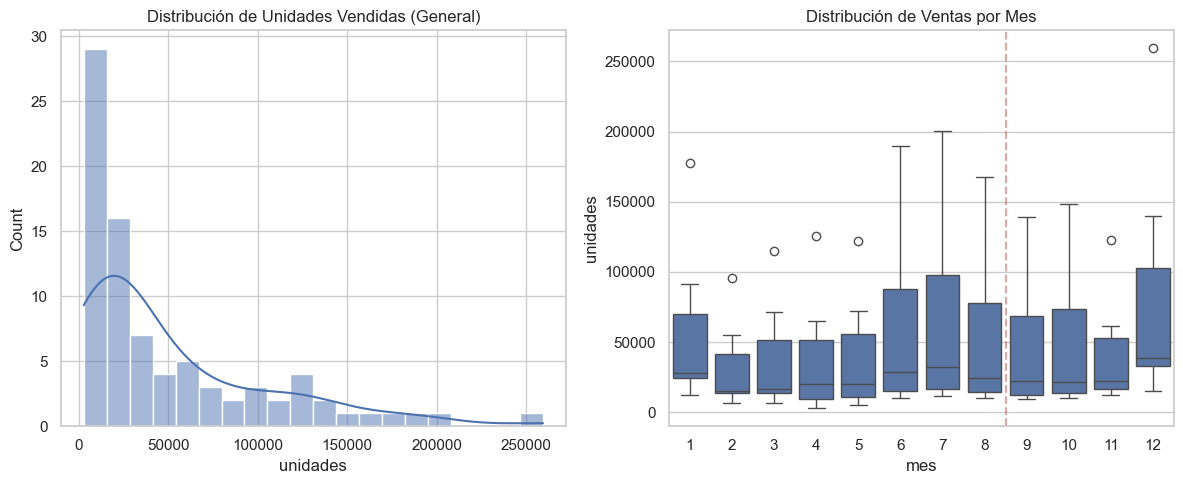

In [4]:
# 4️⃣ Análisis de Distribución de Ventas
# Histograma y Densidad para validar normalidad (importante para modelos lineales).

plt.figure(figsize=(12, 5))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df['unidades'], kde=True, bins=20)
plt.title('Distribución de Unidades Vendidas (General)')

# Boxplot Mensual (Para ver estacionalidad)
plt.subplot(1, 2, 2)
df['mes'] = df.index.month
sns.boxplot(data=df, x='mes', y='unidades')
plt.axvline(x=7.5, color='r', linestyle='--', alpha=0.5, label='Feria Flores?')
plt.title('Distribución de Ventas por Mes')

plt.tight_layout()
plt.show()

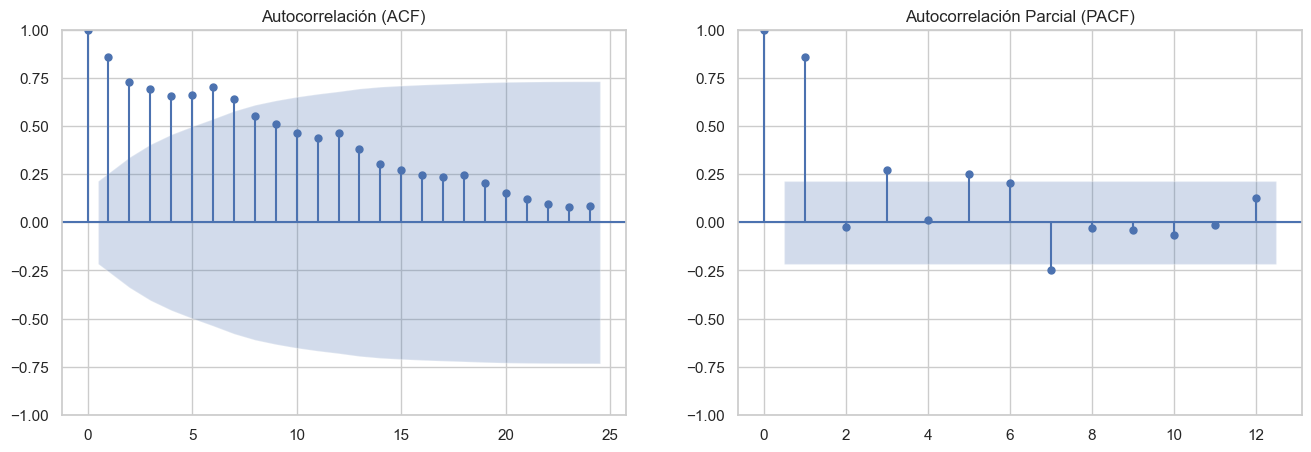

🔍 Interpretación: Barras fuera del área azul indican correlación significativa (posible lag predictor).


In [5]:
# 5️⃣ Análisis de Autocorrelación (ACF / PACF)
# Fundamental para determinar la memoria de la serie (Lags).

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(df['unidades'], lags=24, ax=ax[0])
ax[0].set_title("Autocorrelación (ACF)")

plot_pacf(df['unidades'], lags=12, method='ywm', ax=ax[1])
ax[1].set_title("Autocorrelación Parcial (PACF)")

plt.show()
print("🔍 Interpretación: Barras fuera del área azul indican correlación significativa (posible lag predictor).")

In [6]:
# 6️⃣ Test de Estacionariedad (Dickey-Fuller Augmented)
# Hipótesis Nula (H0): La serie NO es estacionaria (tiene raíz unitaria).
# Si p-value < 0.05, rechazamos H0 y la serie ES estacionaria.

result = adfuller(df['unidades'].dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("✅ La serie ES estacionaria (p-value < 0.05). No requiere diferenciación agresiva.")
else:
    print("❌ La serie NO es estacionaria (p-value >= 0.05). Requiere diferenciación o tratamiento de tendencia.")

ADF Statistic: 1.7548386507871578
p-value: 0.9982551121861377
❌ La serie NO es estacionaria (p-value >= 0.05). Requiere diferenciación o tratamiento de tendencia.


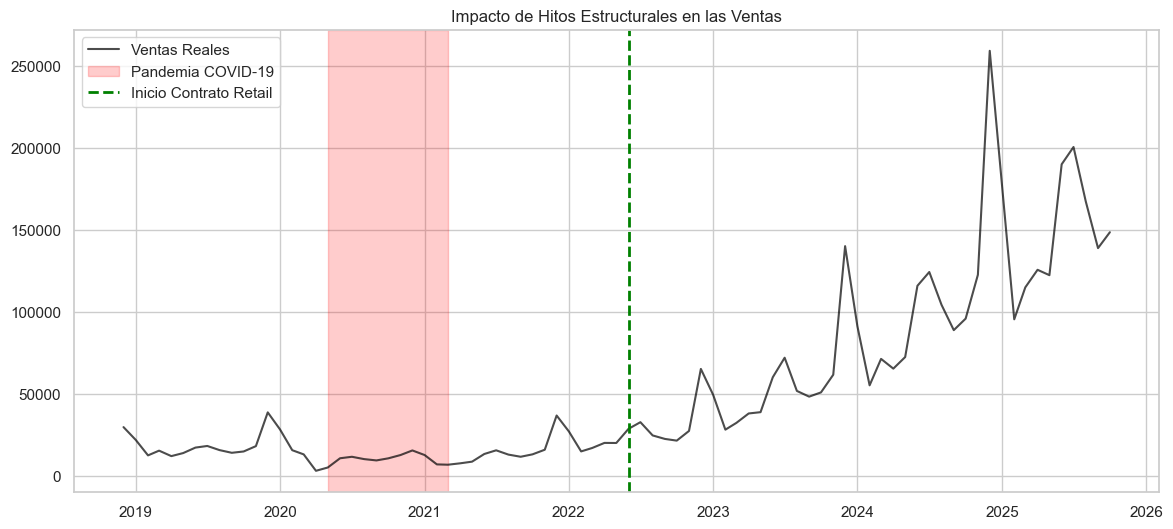

In [7]:
# 7️⃣ Validación de Contexto de Negocio: Hitos Estructurales
# Visualizar impacto de COVID y Contrato Retail sobre la serie.

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['unidades'], label='Ventas Reales', color='black', alpha=0.7)

# Hito: Pandemia
covid_start = config['eda']['business_rules']['structural_breaks']['covid_period']['start']
covid_end = config['eda']['business_rules']['structural_breaks']['covid_period']['end']
plt.axvspan(pd.to_datetime(covid_start), pd.to_datetime(covid_end), color='red', alpha=0.2, label='Pandemia COVID-19')

# Hito: Contrato Retail
retail_start = config['eda']['business_rules']['structural_breaks']['gran_superficie_contract']['start']
plt.axvline(pd.to_datetime(retail_start), color='green', linestyle='--', linewidth=2, label='Inicio Contrato Retail')

plt.title('Impacto de Hitos Estructurales en las Ventas')
plt.legend()
plt.show()

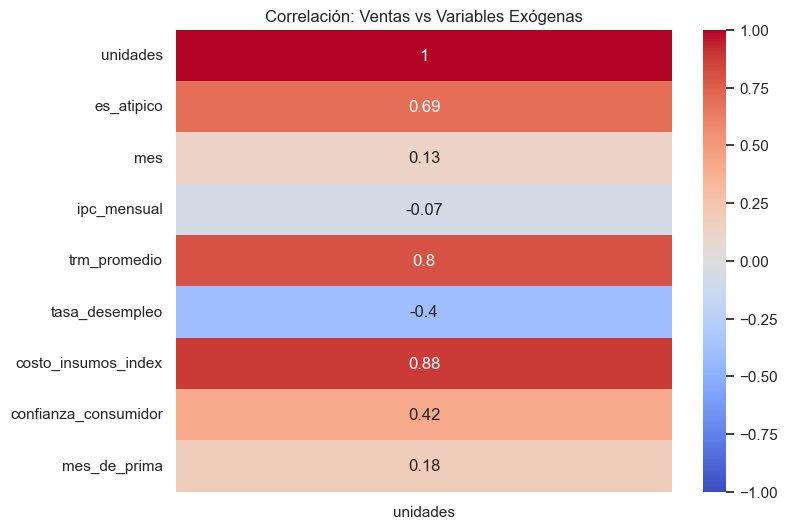

In [8]:
# 8️⃣ Análisis Multivariado: Relación con Variables Macroeconómicas
# Correlación lineal entre Ventas e Indicadores (IPC, TRM)

if 'df_macro' in locals():
    # Unir datasets por fecha (inner join)
    df_merged = df.join(df_macro, how='inner')
    
    if not df_merged.empty:
        # Matriz de Correlación
        corr_matrix = df_merged.corr()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix[['unidades']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Correlación: Ventas vs Variables Exógenas')
        plt.show()
    else:
        print("⚠️ No hay intersección de fechas entre Ventas y Macro.")
else:
    print("⚠️ Dataset macro no cargado, omitiendo análisis.")

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_16476\1488603740.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='n_festivos', y='unidades', ax=axes[0, 0], palette='Blues')
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_16476\1488603740.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='n_fines_semana', y='unidades', ax=axes[0, 1], palette='Greens')
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_16476\1488603740.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='es_feria_flores', y='unidades', ax=axes[

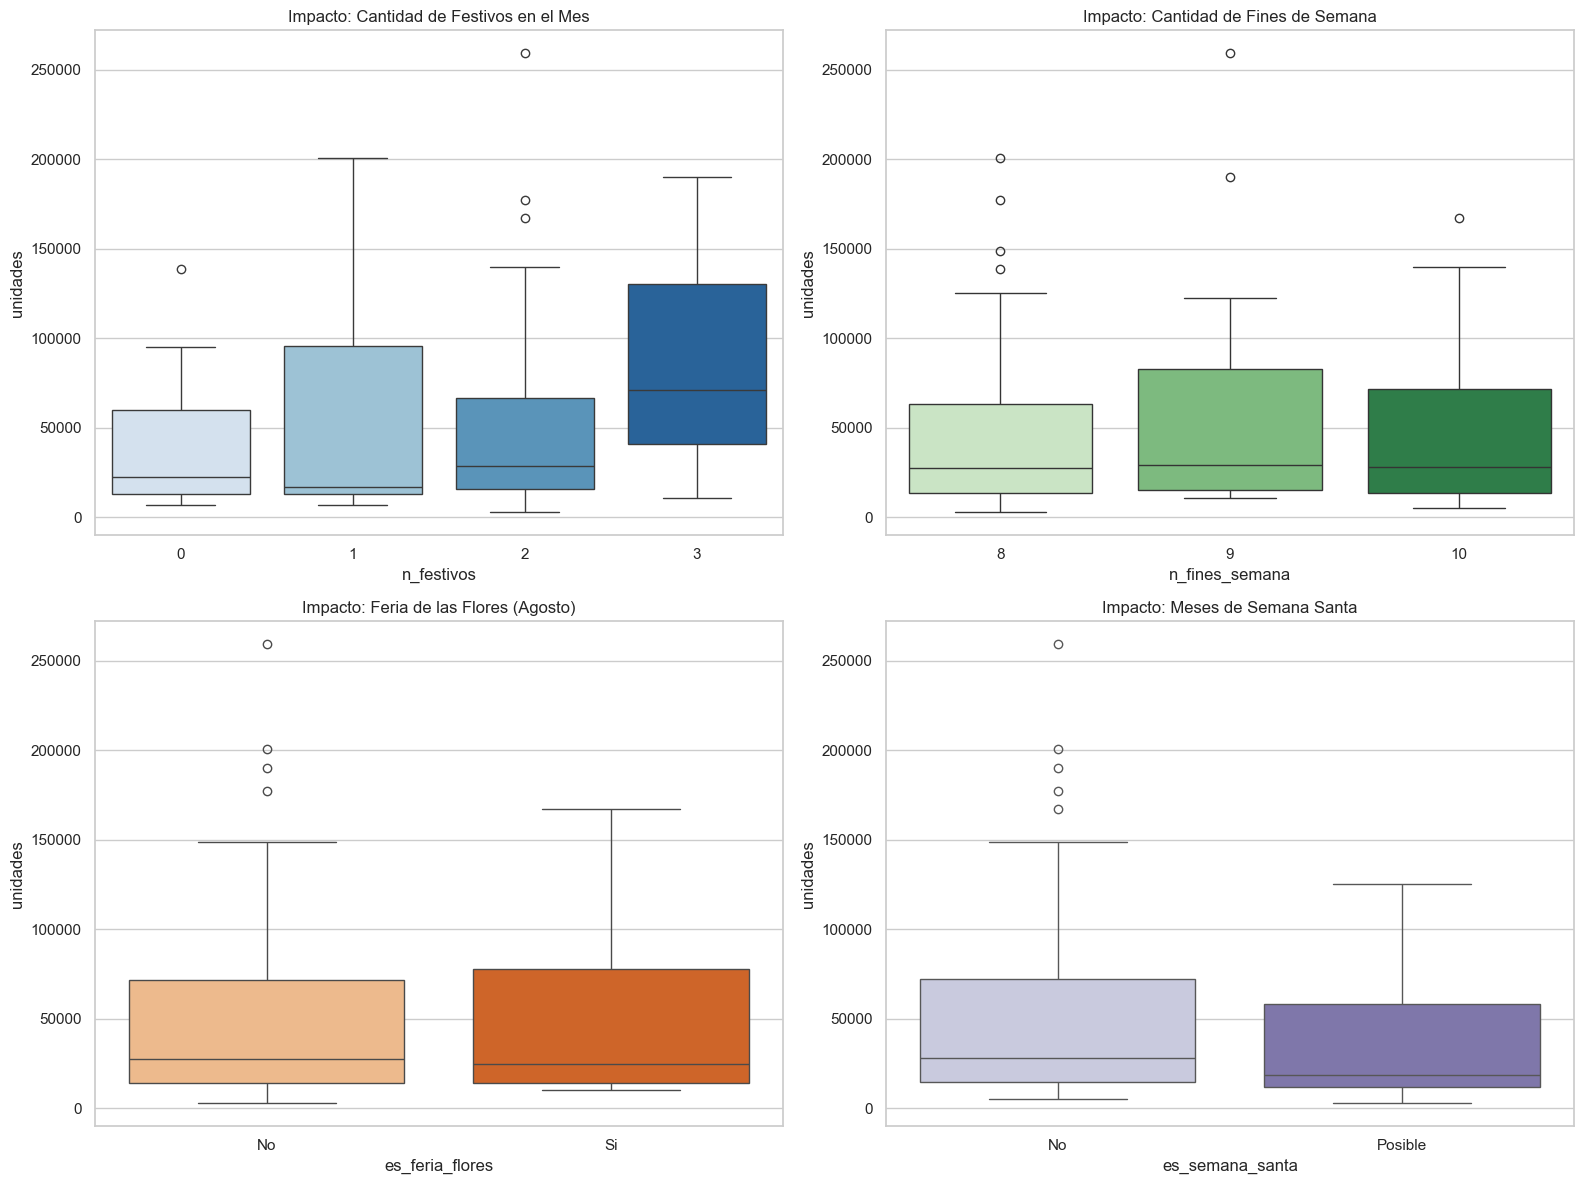

In [9]:
# 9️⃣ Validación de Reglas de Calendario y Eventos
# Objetivo: Cuantificar impacto de festivos, fines de semana y eventos especiales.
import holidays

# 9.1 Calcular Features de Calendario Dinámicamente
# Festivos Colombia
co_holidays = holidays.Colombia()
def contar_festivos(fecha):
    # Muestra cuantos festivos hay en el mes 'fecha'
    dias_en_mes = pd.date_range(start=fecha, periods=fecha.days_in_month, freq='D')
    return sum([1 for d in dias_en_mes if d in co_holidays])

def contar_fines_semana(fecha):
    # Muestra cuantos sabados y domingos hay en el mes
    dias_en_mes = pd.date_range(start=fecha, periods=fecha.days_in_month, freq='D')
    return sum([1 for d in dias_en_mes if d.weekday() >= 5])

df['n_festivos'] = df.index.map(contar_festivos)
df['n_fines_semana'] = df.index.map(contar_fines_semana)

# Eventos Específicos
# Feria Flores: Mes 8 (Agosto)
df['es_feria_flores'] = np.where(df.index.month == 8, 'Si', 'No')
# Semana Santa: Aproximación (Marzo o Abril)
# Nota: Para mayor precisión usaríamos la fecha exacta de Pascua
df['es_semana_santa'] = np.where(df.index.month.isin([3, 4]), 'Posible', 'No')

# 9.2 Visualización de Impacto

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A. Impacto Festivos
sns.boxplot(data=df, x='n_festivos', y='unidades', ax=axes[0, 0], palette='Blues')
axes[0, 0].set_title('Impacto: Cantidad de Festivos en el Mes')

# B. Impacto Fines de Semana
sns.boxplot(data=df, x='n_fines_semana', y='unidades', ax=axes[0, 1], palette='Greens')
axes[0, 1].set_title('Impacto: Cantidad de Fines de Semana')

# C. Impacto Feria de Flores
sns.boxplot(data=df, x='es_feria_flores', y='unidades', ax=axes[1, 0], palette='Oranges')
axes[1, 0].set_title('Impacto: Feria de las Flores (Agosto)')

# D. Impacto Semana Santa (Aproximado)
sns.boxplot(data=df, x='es_semana_santa', y='unidades', ax=axes[1, 1], palette='Purples')
axes[1, 1].set_title('Impacto: Meses de Semana Santa')

plt.tight_layout()
plt.show()